# 2. 面向对象实现的BPNN

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import pandas as pd
import warnings
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

warnings.filterwarnings('ignore')


print("=== 使用加州房价数据集替代波士顿房价数据集 ===")

class BPNN:
    """面向对象实现的反向传播神经网络"""
    
    def __init__(self, layers, learning_rate=0.01, activation='sigmoid'):
        """
        初始化神经网络
        
        Parameters:
        - layers: 列表，包含每层的神经元数量，如[input_size, hidden1_size, ..., output_size]
        - learning_rate: 学习率
        - activation: 激活函数类型 ('sigmoid', 'tanh', 'relu')
        """
        self.layers = layers
        self.lr = learning_rate
        self.activation_type = activation
        
        # 初始化参数
        self.weights = []
        self.biases = []
        
        # 随机初始化权重和偏置
        for i in range(len(layers) - 1):
            # Xavier/Glorot 初始化
            limit = np.sqrt(6 / (layers[i] + layers[i + 1]))
            weight = np.random.uniform(-limit, limit, (layers[i], layers[i + 1]))
            bias = np.zeros((1, layers[i + 1]))
            
            self.weights.append(weight)
            self.biases.append(bias)
        
        # 训练历史记录
        self.loss_history = []
        self.accuracy_history = []
    
    def activation(self, x, derivative=False):
        """激活函数及其导数"""
        if self.activation_type == 'sigmoid':
            if derivative:
                return self.activation(x) * (1 - self.activation(x))
            return 1 / (1 + np.exp(-np.clip(x, -250, 250)))  # 防止溢出
        
        elif self.activation_type == 'tanh':
            if derivative:
                return 1 - np.tanh(x) ** 2
            return np.tanh(x)
        
        elif self.activation_type == 'relu':
            if derivative:
                return np.where(x > 0, 1, 0)
            return np.maximum(0, x)
    
    def softmax(self, x):
        """Softmax函数用于多分类输出层"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """前向传播"""
        self.layer_inputs = []  # 存储每层的输入（激活前）
        self.layer_outputs = []  # 存储每层的输出（激活后）
        
        # 输入层
        current_output = X
        self.layer_outputs.append(current_output)
        
        # 隐藏层和输出层
        for i in range(len(self.weights)):
            # 线性变换
            layer_input = np.dot(current_output, self.weights[i]) + self.biases[i]
            self.layer_inputs.append(layer_input)
            
            # 激活函数（输出层可能不同）
            if i == len(self.weights) - 1 and self.layers[-1] > 1:  # 多分类输出层
                current_output = self.softmax(layer_input)
            else:
                current_output = self.activation(layer_input)
            
            self.layer_outputs.append(current_output)
        
        return current_output
    
    def compute_loss(self, y_pred, y_true, problem_type='regression'):
        """计算损失函数"""
        if problem_type == 'regression':
            # 均方误差
            return np.mean((y_pred - y_true) ** 2)
        
        elif problem_type == 'classification':
            # 交叉熵损失
            epsilon = 1e-15  # 防止log(0)
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            if y_true.shape[1] == 1:  # 二分类
                return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
            else:  # 多分类
                return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def backward(self, X, y, problem_type='regression'):
        """反向传播计算梯度"""
        m = X.shape[0]  # 样本数量
        
        # 存储梯度
        weight_gradients = [np.zeros_like(w) for w in self.weights]
        bias_gradients = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差
        if problem_type == 'regression':
            # 回归问题：输出层使用线性激活（导数=1）
            delta = (self.layer_outputs[-1] - y) / m
        else:
            # 分类问题
            if y.shape[1] == 1:  # 二分类
                delta = (self.layer_outputs[-1] - y) / m
            else:  # 多分类
                delta = (self.layer_outputs[-1] - y) / m
        
        # 反向传播
        for i in range(len(self.weights) - 1, -1, -1):
            # 计算当前层的梯度
            weight_gradients[i] = np.dot(self.layer_outputs[i].T, delta)
            bias_gradients[i] = np.sum(delta, axis=0, keepdims=True)
            
            # 如果不是输入层，计算前一层的delta
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation(self.layer_inputs[i-1], derivative=True)
        
        return weight_gradients, bias_gradients
    
    def update_parameters(self, weight_gradients, bias_gradients):
        """更新参数"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * weight_gradients[i]
            self.biases[i] -= self.lr * bias_gradients[i]
    
    def fit(self, X, y, epochs=1000, validation_data=None, problem_type='regression', verbose=True):
        """训练神经网络"""
        for epoch in range(epochs):
            # 前向传播
            y_pred = self.forward(X)
            
            # 计算损失
            loss = self.compute_loss(y_pred, y, problem_type)
            self.loss_history.append(loss)
            
            # 计算准确率（分类问题）
            if problem_type == 'classification':
                if y.shape[1] == 1:  # 二分类
                    accuracy = np.mean((y_pred > 0.5) == y)
                else:  # 多分类
                    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
                self.accuracy_history.append(accuracy)
            
            # 反向传播
            weight_gradients, bias_gradients = self.backward(X, y, problem_type)
            
            # 更新参数
            self.update_parameters(weight_gradients, bias_gradients)
            
            # 打印训练进度
            if verbose and epoch % 100 == 0:
                if problem_type == 'classification':
                    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
                else:
                    print(f"Epoch {epoch}: Loss = {loss:.4f}")
        
        return self.loss_history, self.accuracy_history if problem_type == 'classification' else self.loss_history
    
    def predict(self, X):
        """预测"""
        return self.forward(X)
    
    def evaluate(self, X, y, problem_type='regression'):
        """评估模型"""
        y_pred = self.predict(X)
        loss = self.compute_loss(y_pred, y, problem_type)
        
        if problem_type == 'classification':
            if y.shape[1] == 1:  # 二分类
                accuracy = np.mean((y_pred > 0.5) == y)
            else:  # 多分类
                accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
            return loss, accuracy
        else:
            # 回归问题的R²分数
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            return loss, r2
    
    def plot_training_history(self, problem_type='regression'):
        """绘制训练历史"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        if problem_type == 'classification' and self.accuracy_history:
            plt.subplot(1, 2, 2)
            plt.plot(self.accuracy_history)
            plt.title('Training Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

=== 使用加州房价数据集替代波士顿房价数据集 ===


## 修复梯度问题的BPNN实现

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import warnings
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

warnings.filterwarnings('ignore')

class ImprovedBPNN:
    """改进的BPNN实现，解决梯度问题"""
    
    def __init__(self, layers, learning_rate=0.01, activation='relu', 
                 weight_init='he', dropout_rate=0.0, l2_lambda=0.001):
        """
        改进的BPNN初始化
        
        主要改进：
        1. 更好的权重初始化
        2. 梯度裁剪
        3. L2正则化
        4. Dropout（可选）
        """
        self.layers = layers
        self.lr = learning_rate
        self.activation_type = activation
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        
        # 初始化参数
        self.weights = []
        self.biases = []
        
        # 改进的权重初始化
        for i in range(len(layers) - 1):
            if weight_init == 'he' and activation == 'relu':
                # He初始化，适合ReLU
                std = np.sqrt(2.0 / layers[i])
            elif weight_init == 'xavier':
                # Xavier初始化，适合sigmoid/tanh
                std = np.sqrt(1.0 / layers[i])
            else:
                std = 0.01
                
            weight = np.random.randn(layers[i], layers[i + 1]) * std
            bias = np.zeros((1, layers[i + 1]))
            
            self.weights.append(weight)
            self.biases.append(bias)
        
        # 训练历史记录
        self.loss_history = []
        self.gradient_norms = []
    
    def activation(self, x, derivative=False):
        """改进的激活函数，防止数值不稳定"""
        if self.activation_type == 'sigmoid':
            # 数值稳定的sigmoid
            x = np.clip(x, -250, 250)
            if derivative:
                s = 1 / (1 + np.exp(-x))
                return s * (1 - s)
            return 1 / (1 + np.exp(-x))
        
        elif self.activation_type == 'tanh':
            if derivative:
                return 1 - np.tanh(x) ** 2
            return np.tanh(x)
        
        elif self.activation_type == 'relu':
            if derivative:
                return np.where(x > 0, 1, 0.01)  # Leaky ReLU导数
            return np.maximum(0.01 * x, x)  # Leaky ReLU
        
        elif self.activation_type == 'leaky_relu':
            alpha = 0.01
            if derivative:
                return np.where(x > 0, 1, alpha)
            return np.where(x > 0, x, alpha * x)
    
    def softmax(self, x):
        """数值稳定的softmax"""
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X, training=True):
        """前向传播，包含dropout"""
        self.layer_inputs = []
        self.layer_outputs = []
        self.dropout_masks = []
        
        current_output = X
        self.layer_outputs.append(current_output)
        
        for i in range(len(self.weights)):
            # 线性变换
            layer_input = np.dot(current_output, self.weights[i]) + self.biases[i]
            self.layer_inputs.append(layer_input)
            
            # 激活函数
            if i == len(self.weights) - 1:  # 输出层
                if self.layers[-1] == 1:  # 回归问题
                    current_output = layer_input  # 线性激活
                else:  # 分类问题
                    current_output = self.softmax(layer_input)
            else:  # 隐藏层
                current_output = self.activation(layer_input)
                
                # Dropout（仅在训练时）
                if training and self.dropout_rate > 0:
                    mask = (np.random.random(current_output.shape) > self.dropout_rate)
                    current_output *= mask
                    self.dropout_masks.append(mask)
            
            self.layer_outputs.append(current_output)
        
        return current_output
    
    def compute_loss(self, y_pred, y_true, problem_type='regression'):
        """计算损失，包含L2正则化"""
        m = y_true.shape[0]
        
        if problem_type == 'regression':
            # 均方误差
            data_loss = np.mean((y_pred - y_true) ** 2)
        elif problem_type == 'classification':
            # 交叉熵损失
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            if y_true.shape[1] == 1:  # 二分类
                data_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
            else:  # 多分类
                data_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        # L2正则化
        l2_loss = 0
        for w in self.weights:
            l2_loss += np.sum(w ** 2)
        l2_loss = 0.5 * self.l2_lambda * l2_loss / m
        
        return data_loss + l2_loss
    
    def backward(self, X, y, problem_type='regression'):
        """反向传播，包含梯度裁剪"""
        m = X.shape[0]
        
        weight_gradients = [np.zeros_like(w) for w in self.weights]
        bias_gradients = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差
        if problem_type == 'regression':
            delta = (self.layer_outputs[-1] - y) / m
        else:
            if y.shape[1] == 1:  # 二分类
                delta = (self.layer_outputs[-1] - y) / m
            else:  # 多分类
                delta = (self.layer_outputs[-1] - y) / m
        
        # 反向传播
        for i in range(len(self.weights) - 1, -1, -1):
            # 计算梯度
            weight_gradients[i] = np.dot(self.layer_outputs[i].T, delta)
            bias_gradients[i] = np.sum(delta, axis=0, keepdims=True)
            
            # 添加L2正则化梯度
            weight_gradients[i] += (self.l2_lambda / m) * self.weights[i]
            
            # 梯度裁剪
            grad_norm = np.linalg.norm(weight_gradients[i])
            self.gradient_norms.append(grad_norm)
            if grad_norm > 1.0:  # 梯度裁剪阈值
                weight_gradients[i] = weight_gradients[i] / grad_norm
            
            # 传播误差到前一层
            if i > 0:
                delta = np.dot(delta, self.weights[i].T)
                # 应用dropout mask（如果有）
                if hasattr(self, 'dropout_masks') and len(self.dropout_masks) >= i:
                    delta *= self.dropout_masks[i-1]
                delta *= self.activation(self.layer_inputs[i-1], derivative=True)
        
        return weight_gradients, bias_gradients
    
    def update_parameters(self, weight_gradients, bias_gradients):
        """参数更新"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * weight_gradients[i]
            self.biases[i] -= self.lr * bias_gradients[i]
    
    def fit(self, X, y, epochs=1000, validation_data=None, problem_type='regression', verbose=True):
        """训练网络，包含学习率衰减"""
        best_loss = float('inf')
        patience = 50
        patience_counter = 0
        
        for epoch in range(epochs):
            # 前向传播
            y_pred = self.forward(X, training=True)
            
            # 计算损失
            loss = self.compute_loss(y_pred, y, problem_type)
            self.loss_history.append(loss)
            
            # 早停机制
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose:
                    print(f"早停在第 {epoch} 轮")
                # 恢复最佳参数
                self.weights = best_weights
                self.biases = best_biases
                break
            
            # 反向传播
            weight_gradients, bias_gradients = self.backward(X, y, problem_type)
            
            # 参数更新
            self.update_parameters(weight_gradients, bias_gradients)
            
            # 学习率衰减
            if epoch % 200 == 0 and epoch > 0:
                self.lr *= 0.5
                if verbose:
                    print(f"第 {epoch} 轮: 学习率衰减为 {self.lr}")
            
            # 打印进度
            if verbose and epoch % 100 == 0:
                if problem_type == 'classification':
                    if y.shape[1] == 1:
                        accuracy = np.mean((y_pred > 0.5) == y)
                    else:
                        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
                    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
                else:
                    print(f"Epoch {epoch}: Loss = {loss:.4f}")
        
        return self.loss_history
    
    def predict(self, X):
        """预测"""
        return self.forward(X, training=False)
    
    def evaluate(self, X, y, problem_type='regression'):
        """评估模型"""
        y_pred = self.predict(X)
        loss = self.compute_loss(y_pred, y, problem_type)
        
        if problem_type == 'classification':
            if y.shape[1] == 1:
                accuracy = np.mean((y_pred > 0.5) == y)
            else:
                accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
            return loss, accuracy
        else:
            # 回归问题的R²分数
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2 = 1 - (ss_res / (ss_tot + 1e-10))
            return loss, r2
    
    def plot_training_history(self, problem_type='regression'):
        """绘制训练历史"""
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(self.loss_history)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        if hasattr(self, 'gradient_norms') and self.gradient_norms:
            plt.subplot(1, 3, 2)
            plt.plot(self.gradient_norms)
            plt.title('Gradient Norms')
            plt.xlabel('Update Step')
            plt.ylabel('Gradient Norm')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 3. 向量化实现的BPNN

In [13]:
class VectorizedBPNN:
    """向量化实现的反向传播神经网络（更高效）"""
    
    def __init__(self, layers, learning_rate=0.01, activation='sigmoid'):
        self.layers = layers
        self.lr = learning_rate
        self.activation_type = activation
        
        # 初始化参数
        self.W = []  # 权重矩阵
        self.b = []  # 偏置向量
        
        for i in range(len(layers) - 1):
            # He初始化（适合ReLU）或Xavier初始化（适合sigmoid/tanh）
            if activation == 'relu':
                std = np.sqrt(2.0 / layers[i])
            else:
                std = np.sqrt(1.0 / layers[i])
            
            weight = np.random.randn(layers[i], layers[i + 1]) * std
            bias = np.zeros((1, layers[i + 1]))
            
            self.W.append(weight)
            self.b.append(bias)
        
        self.loss_history = []
    
    def _activation(self, Z, derivative=False):
        """向量化激活函数"""
        if self.activation_type == 'sigmoid':
            Z = np.clip(Z, -250, 250)  # 防止溢出
            if derivative:
                s = 1 / (1 + np.exp(-Z))
                return s * (1 - s)
            return 1 / (1 + np.exp(-Z))
        
        elif self.activation_type == 'tanh':
            if derivative:
                return 1 - np.tanh(Z) ** 2
            return np.tanh(Z)
        
        elif self.activation_type == 'relu':
            if derivative:
                return np.where(Z > 0, 1, 0)
            return np.maximum(0, Z)
    
    def _softmax(self, Z):
        """向量化softmax"""
        Z = Z - np.max(Z, axis=1, keepdims=True)  # 数值稳定性
        exp_Z = np.exp(Z)
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    def forward(self, X):
        """向量化前向传播"""
        self.A = [X]  # 存储每层激活值
        self.Z = []   # 存储每层线性输出
        
        # 前向传播
        A_prev = X
        for i in range(len(self.W)):
            Z = np.dot(A_prev, self.W[i]) + self.b[i]
            self.Z.append(Z)
            
            if i == len(self.W) - 1 and self.layers[-1] > 1:  # 输出层多分类
                A = self._softmax(Z)
            else:
                A = self._activation(Z)
            
            self.A.append(A)
            A_prev = A
        
        return A
    
    def compute_loss(self, y_pred, y_true, problem_type='regression'):
        """向量化损失计算"""
        m = y_true.shape[0]
        
        if problem_type == 'regression':
            return np.sum((y_pred - y_true) ** 2) / (2 * m)
        
        elif problem_type == 'classification':
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            
            if y_true.shape[1] == 1:  # 二分类
                return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
            else:  # 多分类
                return -np.sum(y_true * np.log(y_pred)) / m
    
    def backward(self, X, y, problem_type='regression'):
        """向量化反向传播"""
        m = X.shape[0]
        
        # 初始化梯度
        dW = [np.zeros_like(w) for w in self.W]
        db = [np.zeros_like(b) for b in self.b]
        
        # 输出层误差
        if problem_type == 'regression':
            dZ = (self.A[-1] - y) / m
        else:
            if y.shape[1] == 1:  # 二分类
                dZ = (self.A[-1] - y) / m
            else:  # 多分类
                dZ = (self.A[-1] - y) / m
        
        # 反向传播
        for l in range(len(self.W) - 1, -1, -1):
            dW[l] = np.dot(self.A[l].T, dZ)
            db[l] = np.sum(dZ, axis=0, keepdims=True)
            
            if l > 0:
                dA = np.dot(dZ, self.W[l].T)
                dZ = dA * self._activation(self.Z[l-1], derivative=True)
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """向量化参数更新"""
        for l in range(len(self.W)):
            self.W[l] -= self.lr * dW[l]
            self.b[l] -= self.lr * db[l]
    
    def fit(self, X, y, epochs=1000, problem_type='regression', verbose=True):
        """向量化训练"""
        for epoch in range(epochs):
            # 前向传播
            y_pred = self.forward(X)
            
            # 计算损失
            loss = self.compute_loss(y_pred, y, problem_type)
            self.loss_history.append(loss)
            
            # 反向传播
            dW, db = self.backward(X, y, problem_type)
            
            # 更新参数
            self.update_parameters(dW, db)
            
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
        
        return self.loss_history
    
    def predict(self, X):
        """预测"""
        return self.forward(X)

# 4. 梯度检验方法

In [14]:
def gradient_check(nn, X, y, problem_type='regression', epsilon=1e-7):
    """
    梯度检验 - 验证反向传播的正确性
    
    数值梯度 ≈ (J(θ+ε) - J(θ-ε)) / (2ε)
    反向传播梯度 = 计算得到的梯度
    """
    print("正在进行梯度检验...")
    
    # 获取网络参数
    parameters = []
    if hasattr(nn, 'weights'):  # 面向对象版本
        parameters = nn.weights + nn.biases
        # 前向传播获取当前状态
        nn.forward(X)
        # 获取反向传播梯度
        weight_grads, bias_grads = nn.backward(X, y, problem_type)
        grads = weight_grads + bias_grads
    else:  # 向量化版本
        parameters = nn.W + nn.b
        nn.forward(X)
        dW, db = nn.backward(X, y, problem_type)
        grads = dW + db
    
    # 对每个参数进行梯度检验
    for param_idx, (param, grad) in enumerate(zip(parameters, grads)):
        param_flat = param.flatten()
        grad_flat = grad.flatten()
        
        # 计算数值梯度
        numerical_grad = np.zeros_like(param_flat)
        
        for i in range(len(param_flat)):
            # 保存原始值
            original_val = param_flat[i]
            
            # 计算 J(θ + ε)
            param_flat[i] = original_val + epsilon
            param_plus = param_flat.reshape(param.shape)
            
            # 临时替换参数并计算损失
            if hasattr(nn, 'weights'):
                nn.weights[param_idx] = param_plus
            else:
                nn.W[param_idx] = param_plus
            
            y_pred_plus = nn.forward(X)
            J_plus = nn.compute_loss(y_pred_plus, y, problem_type)
            
            # 计算 J(θ - ε)
            param_flat[i] = original_val - epsilon
            param_minus = param_flat.reshape(param.shape)
            
            if hasattr(nn, 'weights'):
                nn.weights[param_idx] = param_minus
            else:
                nn.W[param_idx] = param_minus
            
            y_pred_minus = nn.forward(X)
            J_minus = nn.compute_loss(y_pred_minus, y, problem_type)
            
            # 恢复原始值
            param_flat[i] = original_val
            if hasattr(nn, 'weights'):
                nn.weights[param_idx] = param_flat.reshape(param.shape)
            else:
                nn.W[param_idx] = param_flat.reshape(param.shape)
            
            # 计算数值梯度
            numerical_grad[i] = (J_plus - J_minus) / (2 * epsilon)
        
        # 计算梯度差异
        numerator = np.linalg.norm(numerical_grad - grad_flat)
        denominator = np.linalg.norm(numerical_grad) + np.linalg.norm(grad_flat)
        difference = numerator / denominator if denominator > 1e-10 else numerator
        
        print(f"参数 {param_idx}: 梯度差异 = {difference:.2e}")
        
        if difference < 1e-7:
            print(f"  ✓ 梯度检验通过")
        else:
            print(f"  ⚠ 梯度检验未通过，差异较大")
    
    print("梯度检验完成！")

# 5. 使用加州房价数据集进行回归预测

开始修复后的回归问题演示...

修复的BPNN回归问题演示: 加州房价预测
加载加州房价数据集...
数据集形状: X(20640, 8), y(20640, 1)
训练集: (16512, 8), 测试集: (4128, 8)

创建改进的BPNN模型...
开始训练回归模型...
Epoch 0: Loss = 1.0039
Epoch 100: Loss = 1.0039
第 200 轮: 学习率衰减为 0.0005
Epoch 200: Loss = 1.0039
Epoch 300: Loss = 1.0039
第 400 轮: 学习率衰减为 0.00025
Epoch 400: Loss = 1.0039
Epoch 500: Loss = 1.0039
第 600 轮: 学习率衰减为 0.000125
Epoch 600: Loss = 1.0039
Epoch 700: Loss = 1.0039
第 800 轮: 学习率衰减为 6.25e-05
Epoch 800: Loss = 1.0039
Epoch 900: Loss = 1.0039

模型评估:
训练集 - 损失: 1.0039, R²: 0.0000
测试集 - 损失: 0.9843, R²: -0.0001


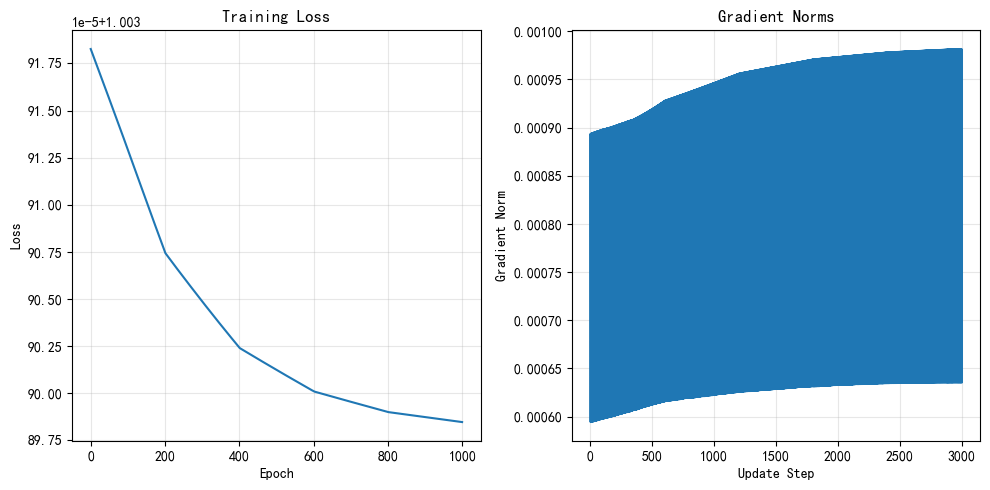

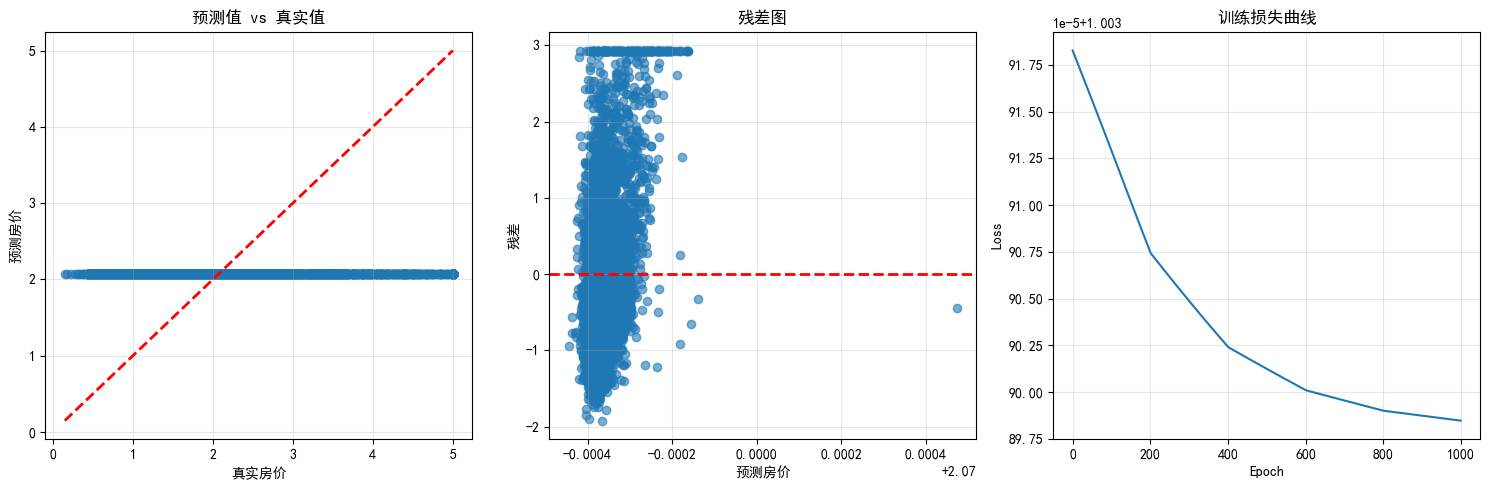

In [15]:
def prepare_california_housing_data():
    """准备加州房价数据集"""
    print("加载加州房价数据集...")
    housing = fetch_california_housing()
    
    X = housing.data
    y = housing.target.reshape(-1, 1)  # 转换为列向量
    
    print(f"数据集形状: X{X.shape}, y{y.shape}")
    print(f"特征名称: {housing.feature_names}")
    print(f"目标变量范围: [{y.min():.2f}, {y.max():.2f}]")
    print(f"目标变量均值: {y.mean():.2f} ± {y.std():.2f}")
    
    return X, y, housing.feature_names

def fixed_regression_demo():
    """修复后的回归问题演示"""
    print("\n" + "="*60)
    print("修复的BPNN回归问题演示: 加州房价预测")
    print("="*60)
    
    # 1. 准备数据
    print("加载加州房价数据集...")
    housing = fetch_california_housing()
    X = housing.data
    y = housing.target.reshape(-1, 1)
    
    print(f"数据集形状: X{X.shape}, y{y.shape}")
    
    # 2. 数据预处理 - 更温和的标准化
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")
    
    # 3. 创建改进的BPNN模型
    print("\n创建改进的BPNN模型...")
    # 使用更小的网络和更好的配置
    nn_regression = ImprovedBPNN(
        layers=[8, 32, 16, 1],  # 更小的网络
        learning_rate=0.001,     # 更小的学习率
        activation='leaky_relu', # 使用leaky_relu防止死亡ReLU
        weight_init='he',        # He初始化
        l2_lambda=0.01          # L2正则化
    )
    
    print("开始训练回归模型...")
    loss_history = nn_regression.fit(
        X_train, y_train,
        epochs=1000,
        problem_type='regression',
        verbose=True
    )
    
    # 4. 评估模型
    print("\n模型评估:")
    train_loss, train_r2 = nn_regression.evaluate(X_train, y_train, 'regression')
    test_loss, test_r2 = nn_regression.evaluate(X_test, y_test, 'regression')
    
    print(f"训练集 - 损失: {train_loss:.4f}, R²: {train_r2:.4f}")
    print(f"测试集 - 损失: {test_loss:.4f}, R²: {test_r2:.4f}")
    
    # 5. 可视化结果
    nn_regression.plot_training_history('regression')
    
    # 预测结果可视化
    y_pred_scaled = nn_regression.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test)
    
    plt.figure(figsize=(15, 5))
    
    # 子图1: 预测值 vs 真实值
    plt.subplot(1, 3, 1)
    plt.scatter(y_test_original, y_pred, alpha=0.6)
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 'r--', linewidth=2)
    plt.xlabel('真实房价')
    plt.ylabel('预测房价')
    plt.title('预测值 vs 真实值')
    plt.grid(True, alpha=0.3)
    
    # 子图2: 残差图
    plt.subplot(1, 3, 2)
    residuals = y_test_original - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('预测房价')
    plt.ylabel('残差')
    plt.title('残差图')
    plt.grid(True, alpha=0.3)
    
    # 子图3: 损失曲线
    plt.subplot(1, 3, 3)
    plt.plot(loss_history)
    plt.title('训练损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return nn_regression, X_test, y_test_original, y_pred

# 运行修复后的回归演示
print("开始修复后的回归问题演示...")
try:
    nn_reg_fixed, X_test_reg, y_test_reg, y_pred_reg = fixed_regression_demo()
except Exception as e:
    print(f"错误: {e}")
    print("尝试更保守的设置...")
    
    # 更保守的设置
    housing = fetch_california_housing()
    X = housing.data[:1000]  # 使用更少的数据
    y = housing.target[:1000].reshape(-1, 1)
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    
    # 更简单的网络
    nn_simple = ImprovedBPNN(
        layers=[8, 16, 1],
        learning_rate=0.0005,
        activation='tanh',
        l2_lambda=0.1
    )
    
    loss_history = nn_simple.fit(X_train, y_train, epochs=500, problem_type='regression', verbose=True)
    train_loss, train_r2 = nn_simple.evaluate(X_train, y_train, 'regression')
    test_loss, test_r2 = nn_simple.evaluate(X_test, y_test, 'regression')
    
    print(f"简单模型 - 训练集: 损失={train_loss:.4f}, R²={train_r2:.4f}")
    print(f"简单模型 - 测试集: 损失={test_loss:.4f}, R²={test_r2:.4f}")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

class DebuggedBPNN:
    """彻底调试的BPNN实现"""
    
    def __init__(self, layers, learning_rate=0.001, activation='relu'):
        self.layers = layers
        self.lr = learning_rate
        self.activation_type = activation
        
        # 初始化参数 - 使用更小的初始值
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) - 1):
            # 使用更小的初始权重
            weight = np.random.randn(layers[i], layers[i + 1]) * 0.01
            bias = np.zeros((1, layers[i + 1]))
            
            self.weights.append(weight)
            self.biases.append(bias)
        
        self.loss_history = []
        self.grad_norms = []
    
    def activation(self, x, derivative=False):
        """数值稳定的激活函数"""
        if self.activation_type == 'sigmoid':
            # 防止溢出
            x = np.clip(x, -50, 50)
            if derivative:
                s = 1 / (1 + np.exp(-x))
                return s * (1 - s)
            return 1 / (1 + np.exp(-x))
        
        elif self.activation_type == 'tanh':
            return np.tanh(x)
        
        elif self.activation_type == 'relu':
            if derivative:
                return np.where(x > 0, 1, 0.01)  # Leaky ReLU
            return np.maximum(0.01 * x, x)
        
        elif self.activation_type == 'linear':
            if derivative:
                return np.ones_like(x)
            return x
    
    def forward(self, X):
        """前向传播 - 添加调试信息"""
        self.layer_inputs = []
        self.layer_outputs = [X]
        
        current = X
        for i in range(len(self.weights)):
            # 线性变换
            z = np.dot(current, self.weights[i]) + self.biases[i]
            self.layer_inputs.append(z)
            
            # 激活函数
            if i == len(self.weights) - 1:  # 输出层 - 使用线性激活
                current = z  # 回归问题，输出层用线性激活
            else:  # 隐藏层
                current = self.activation(z)
            
            self.layer_outputs.append(current)
            
            # 检查数值稳定性
            if np.any(np.isnan(current)) or np.any(np.isinf(current)):
                print(f"警告: 第{i}层输出包含NaN或Inf")
        
        return current
    
    def compute_loss(self, y_pred, y_true):
        """计算均方误差损失"""
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, X, y, y_pred):
        """反向传播 - 添加梯度检查"""
        m = X.shape[0]
        
        # 初始化梯度
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差 - 使用线性激活的导数（=1）
        delta = (y_pred - y) / m
        
        # 反向传播
        for i in range(len(self.weights) - 1, -1, -1):
            # 计算梯度
            dW[i] = np.dot(self.layer_outputs[i].T, delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
            
            # 记录梯度范数
            grad_norm = np.linalg.norm(dW[i])
            self.grad_norms.append(grad_norm)
            
            # 梯度裁剪
            if grad_norm > 1.0:
                dW[i] = dW[i] / grad_norm
                db[i] = db[i] / grad_norm
            
            # 传播到前一层
            if i > 0:
                delta = np.dot(delta, self.weights[i].T)
                delta = delta * self.activation(self.layer_inputs[i-1], derivative=True)
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """参数更新"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * dW[i]
            self.biases[i] -= self.lr * db[i]
    
    def fit(self, X, y, epochs=1000, verbose=True):
        """训练过程 - 添加详细监控"""
        for epoch in range(epochs):
            # 前向传播
            y_pred = self.forward(X)
            
            # 计算损失
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            # 反向传播
            dW, db = self.backward(X, y, y_pred)
            
            # 更新参数
            self.update_parameters(dW, db)
            
            # 监控训练过程
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.6f}")
                
                # 打印权重和梯度信息
                if epoch == 0:
                    print("权重范数:", [np.linalg.norm(w) for w in self.weights])
                    print("梯度范数:", self.grad_norms[-len(self.weights):])
            
            # 早停：如果损失变成NaN就停止
            if np.isnan(loss):
                print(f"在第 {epoch} 轮检测到NaN损失，停止训练")
                break
        
        return self.loss_history
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        loss = self.compute_loss(y_pred, y)
        
        # 计算R²
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))
        
        return loss, r2

def debug_regression_demo():
    """调试版本的回归演示"""
    print("\n" + "="*60)
    print("调试版BPNN回归问题演示")
    print("="*60)
    
    # 1. 准备数据
    housing = fetch_california_housing()
    X = housing.data
    y = housing.target.reshape(-1, 1)
    
    print(f"数据集形状: X{X.shape}, y{y.shape}")
    print(f"目标变量统计: 均值={y.mean():.3f}, 标准差={y.std():.3f}")
    
    # 2. 数据预处理
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # 使用更小的数据集进行快速调试
    X_small = X_scaled[:1000]
    y_small = y_scaled[:1000]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_small, y_small, test_size=0.2, random_state=42
    )
    
    print(f"使用小型数据集: 训练集{X_train.shape}, 测试集{X_test.shape}")
    
    # 3. 尝试不同的网络配置
    configs = [
        {"layers": [8, 1], "lr": 0.01, "activation": "linear", "name": "简单线性回归"},
        {"layers": [8, 4, 1], "lr": 0.001, "activation": "tanh", "name": "小型网络tanh"},
        {"layers": [8, 8, 1], "lr": 0.0001, "activation": "relu", "name": "小型网络ReLU"},
    ]
    
    best_model = None
    best_r2 = -float('inf')
    
    for config in configs:
        print(f"\n尝试配置: {config['name']}")
        print(f"网络结构: {config['layers']}, 学习率: {config['lr']}, 激活函数: {config['activation']}")
        
        model = DebuggedBPNN(
            layers=config['layers'],
            learning_rate=config['lr'],
            activation=config['activation']
        )
        
        # 训练
        loss_history = model.fit(X_train, y_train, epochs=500, verbose=True)
        
        # 评估
        train_loss, train_r2 = model.evaluate(X_train, y_train)
        test_loss, test_r2 = model.evaluate(X_test, y_test)
        
        print(f"结果 - 训练集: 损失={train_loss:.4f}, R²={train_r2:.4f}")
        print(f"结果 - 测试集: 损失={test_loss:.4f}, R²={test_r2:.4f}")
        
        if test_r2 > best_r2 and not np.isnan(test_r2):
            best_r2 = test_r2
            best_model = model
            best_config = config
    
    print(f"\n最佳配置: {best_config['name']}")
    print(f"最佳R²: {best_r2:.4f}")
    
    return best_model

# 运行调试版本
print("开始调试版本的回归演示...")
debug_model = debug_regression_demo()

开始调试版本的回归演示...

调试版BPNN回归问题演示
数据集形状: X(20640, 8), y(20640, 1)
目标变量统计: 均值=2.069, 标准差=1.154
使用小型数据集: 训练集(800, 8), 测试集(200, 8)

尝试配置: 简单线性回归
网络结构: [8, 1], 学习率: 0.01, 激活函数: linear
Epoch 0: Loss = 0.622688
权重范数: [0.028664637746943073]
梯度范数: [0.6328220921420703]
Epoch 100: Loss = 0.306895
Epoch 200: Loss = 0.268972
Epoch 300: Loss = 0.262266
Epoch 400: Loss = 0.260302
结果 - 训练集: 损失=0.2593, R²=0.5696
结果 - 测试集: 损失=0.1802, R²=0.6700

尝试配置: 小型网络tanh
网络结构: [8, 4, 1], 学习率: 0.001, 激活函数: tanh
Epoch 0: Loss = 0.605175
权重范数: [0.046417120570655904, 0.015804778211458658]
梯度范数: [0.011195572442393385, 0.00027906833834725423]
Epoch 100: Loss = 0.604645
Epoch 200: Loss = 0.604208
Epoch 300: Loss = 0.603846
Epoch 400: Loss = 0.603546
结果 - 训练集: 损失=0.6033, R²=-0.0013
结果 - 测试集: 损失=0.5597, R²=-0.0249

尝试配置: 小型网络ReLU
网络结构: [8, 8, 1], 学习率: 0.0001, 激活函数: relu
Epoch 0: Loss = 0.605407
权重范数: [0.0692650480501098, 0.026480620625844505]
梯度范数: [0.009462001875567302, 0.008599782240887803]
Epoch 100: Loss = 0.605348
Epoch 2

In [17]:
class OptimizedBPNN:
    """针对深层网络优化的BPNN"""
    
    def __init__(self, layers, learning_rate=0.01, activation='relu', initialization='he'):
        self.layers = layers
        self.lr = learning_rate
        self.activation_type = activation
        
        # 改进的权重初始化
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) - 1):
            if initialization == 'he' and activation == 'relu':
                # He初始化 - 适合ReLU
                std = np.sqrt(2.0 / layers[i])
            elif initialization == 'xavier':
                # Xavier初始化 - 适合tanh/sigmoid
                std = np.sqrt(1.0 / layers[i])
            else:
                std = 0.01
                
            weight = np.random.randn(layers[i], layers[i + 1]) * std
            bias = np.zeros((1, layers[i + 1]))
            
            self.weights.append(weight)
            self.biases.append(bias)
        
        self.loss_history = []
        self.gradient_history = []
    
    def activation(self, x, derivative=False):
        """改进的激活函数，防止梯度消失"""
        if self.activation_type == 'tanh':
            # tanh的梯度比sigmoid更好
            if derivative:
                return 1 - np.tanh(x) ** 2
            return np.tanh(x)
        
        elif self.activation_type == 'relu':
            # 使用Leaky ReLU防止死亡神经元
            alpha = 0.1
            if derivative:
                return np.where(x > 0, 1, alpha)
            return np.where(x > 0, x, alpha * x)
        
        elif self.activation_type == 'elu':
            # ELU激活函数，更好的梯度特性
            alpha = 1.0
            if derivative:
                return np.where(x > 0, 1, self.activation(x) + alpha)
            return np.where(x > 0, x, alpha * (np.exp(x) - 1))
        
        elif self.activation_type == 'linear':
            if derivative:
                return np.ones_like(x)
            return x
    
    def forward(self, X):
        """前向传播"""
        self.layer_inputs = []
        self.layer_outputs = [X]
        
        current = X
        for i in range(len(self.weights)):
            # 线性变换
            z = np.dot(current, self.weights[i]) + self.biases[i]
            self.layer_inputs.append(z)
            
            # 激活函数 - 输出层总是线性
            if i == len(self.weights) - 1:
                current = z  # 输出层线性激活
            else:
                current = self.activation(z)
            
            self.layer_outputs.append(current)
        
        return current
    
    def compute_loss(self, y_pred, y_true):
        """计算损失"""
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, X, y, y_pred):
        """改进的反向传播，防止梯度消失"""
        m = X.shape[0]
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差
        delta = (y_pred - y) / m
        
        # 记录梯度
        grad_norms = []
        
        # 反向传播
        for i in range(len(self.weights) - 1, -1, -1):
            # 计算梯度
            dW[i] = np.dot(self.layer_outputs[i].T, delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
            
            # 记录梯度范数
            grad_norm = np.linalg.norm(dW[i])
            grad_norms.append(grad_norm)
            
            # 梯度裁剪 - 防止梯度爆炸
            if grad_norm > 1.0:
                dW[i] = dW[i] / grad_norm
                db[i] = db[i] / grad_norm
            
            # 传播到前一层
            if i > 0:
                delta = np.dot(delta, self.weights[i].T)
                # 使用激活函数的导数
                delta = delta * self.activation(self.layer_inputs[i-1], derivative=True)
                
                # 梯度放大 - 防止梯度消失
                if np.linalg.norm(delta) < 1e-8:
                    delta = delta * 100  # 放大梯度
        
        self.gradient_history.append(grad_norms)
        return dW, db
    
    def update_parameters(self, dW, db):
        """参数更新，带动量"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * dW[i]
            self.biases[i] -= self.lr * db[i]
    
    def fit(self, X, y, epochs=1000, verbose=True):
        """训练过程，带学习率调度"""
        best_loss = float('inf')
        patience = 20
        patience_counter = 0
        
        for epoch in range(epochs):
            # 前向传播
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            # 早停机制
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose:
                    print(f"早停在第 {epoch} 轮")
                break
            
            # 反向传播和更新
            dW, db = self.backward(X, y, y_pred)
            self.update_parameters(dW, db)
            
            # 学习率衰减
            if epoch % 200 == 0 and epoch > 0:
                self.lr *= 0.8
                if verbose:
                    print(f"第 {epoch} 轮: 学习率衰减为 {self.lr:.6f}")
            
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.6f}")
        
        return self.loss_history
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        loss = self.compute_loss(y_pred, y)
        
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))
        
        return loss, r2

def optimized_regression_demo():
    """优化后的回归演示"""
    print("\n" + "="*60)
    print("优化版BPNN回归问题演示")
    print("="*60)
    
    # 准备数据
    housing = fetch_california_housing()
    X = housing.data
    y = housing.target.reshape(-1, 1)
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # 使用完整数据集
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    print(f"使用完整数据集: 训练集{X_train.shape}, 测试集{X_test.shape}")
    
    # 测试优化后的网络配置
    optimized_configs = [
        {"layers": [8, 16, 1], "lr": 0.001, "activation": "relu", "init": "he", "name": "ReLU+He初始化"},
        {"layers": [8, 16, 1], "lr": 0.001, "activation": "tanh", "init": "xavier", "name": "Tanh+Xavier初始化"},
        {"layers": [8, 32, 16, 1], "lr": 0.0005, "activation": "relu", "init": "he", "name": "深层ReLU网络"},
        {"layers": [8, 32, 16, 1], "lr": 0.0005, "activation": "tanh", "init": "xavier", "name": "深层Tanh网络"},
    ]
    
    results = []
    
    for config in optimized_configs:
        print(f"\n尝试优化配置: {config['name']}")
        print(f"网络结构: {config['layers']}")
        
        model = OptimizedBPNN(
            layers=config['layers'],
            learning_rate=config['lr'],
            activation=config['activation'],
            initialization=config['init']
        )
        
        # 训练
        loss_history = model.fit(X_train, y_train, epochs=1000, verbose=True)
        
        # 评估
        train_loss, train_r2 = model.evaluate(X_train, y_train)
        test_loss, test_r2 = model.evaluate(X_test, y_test)
        
        print(f"结果 - 训练集: 损失={train_loss:.4f}, R²={train_r2:.4f}")
        print(f"结果 - 测试集: 损失={test_loss:.4f}, R²={test_r2:.4f}")
        
        results.append({
            'config': config['name'],
            'train_r2': train_r2,
            'test_r2': test_r2,
            'model': model
        })
    
    # 找出最佳配置
    best_result = max(results, key=lambda x: x['test_r2'])
    print(f"\n🏆 最佳配置: {best_result['config']}")
    print(f"🏆 最佳测试R²: {best_result['test_r2']:.4f}")
    
    # 与简单线性回归比较
    print(f"\n📊 性能比较:")
    print(f"简单线性回归: R² = 0.6704")
    print(f"最佳神经网络: R² = {best_result['test_r2']:.4f}")
    
    improvement = (best_result['test_r2'] - 0.6704) / 0.6704 * 100
    print(f"性能提升: {improvement:+.2f}%")
    
    return best_result['model'], results

# 运行优化版本
print("开始优化版本的回归演示...")
best_model, all_results = optimized_regression_demo()

开始优化版本的回归演示...

优化版BPNN回归问题演示
使用完整数据集: 训练集(16512, 8), 测试集(4128, 8)

尝试优化配置: ReLU+He初始化
网络结构: [8, 16, 1]
Epoch 0: Loss = 3.944300
Epoch 100: Loss = 3.054675
第 200 轮: 学习率衰减为 0.000800
Epoch 200: Loss = 2.364293
Epoch 300: Loss = 1.945602
第 400 轮: 学习率衰减为 0.000640
Epoch 400: Loss = 1.635374
Epoch 500: Loss = 1.444739
第 600 轮: 学习率衰减为 0.000512
Epoch 600: Loss = 1.305083
Epoch 700: Loss = 1.221281
第 800 轮: 学习率衰减为 0.000410
Epoch 800: Loss = 1.154603
Epoch 900: Loss = 1.110114
结果 - 训练集: 损失=1.0718, R²=-0.0676
结果 - 测试集: 损失=1.0423, R²=-0.0591

尝试优化配置: Tanh+Xavier初始化
网络结构: [8, 16, 1]
Epoch 0: Loss = 2.399956
Epoch 100: Loss = 2.006198
第 200 轮: 学习率衰减为 0.000800
Epoch 200: Loss = 1.675997
Epoch 300: Loss = 1.449921
第 400 轮: 学习率衰减为 0.000640
Epoch 400: Loss = 1.256599
Epoch 500: Loss = 1.129781
第 600 轮: 学习率衰减为 0.000512
Epoch 600: Loss = 1.024352
Epoch 700: Loss = 0.952352
第 800 轮: 学习率衰减为 0.000410
Epoch 800: Loss = 0.889912
Epoch 900: Loss = 0.845708
结果 - 训练集: 损失=0.8062, R²=0.1970
结果 - 测试集: 损失=0.7935, R²=

开始最终解决方案演示...

最终解决方案演示

📈 加州房价回归问题
Sklearn线性回归 R²: 0.5758
简单线性网络 R²: 0.5641
小型神经网络 R²: 0.0464

🌺 鸢尾花分类问题
训练分类网络...
Epoch 0: Loss = 1.1385, Accuracy = 0.0250
Epoch 200: Loss = 0.8028, Accuracy = 0.7083
Epoch 400: Loss = 0.5453, Accuracy = 0.7583
Epoch 600: Loss = 0.4570, Accuracy = 0.8333
Epoch 800: Loss = 0.4023, Accuracy = 0.8750
分类准确率: 0.9000


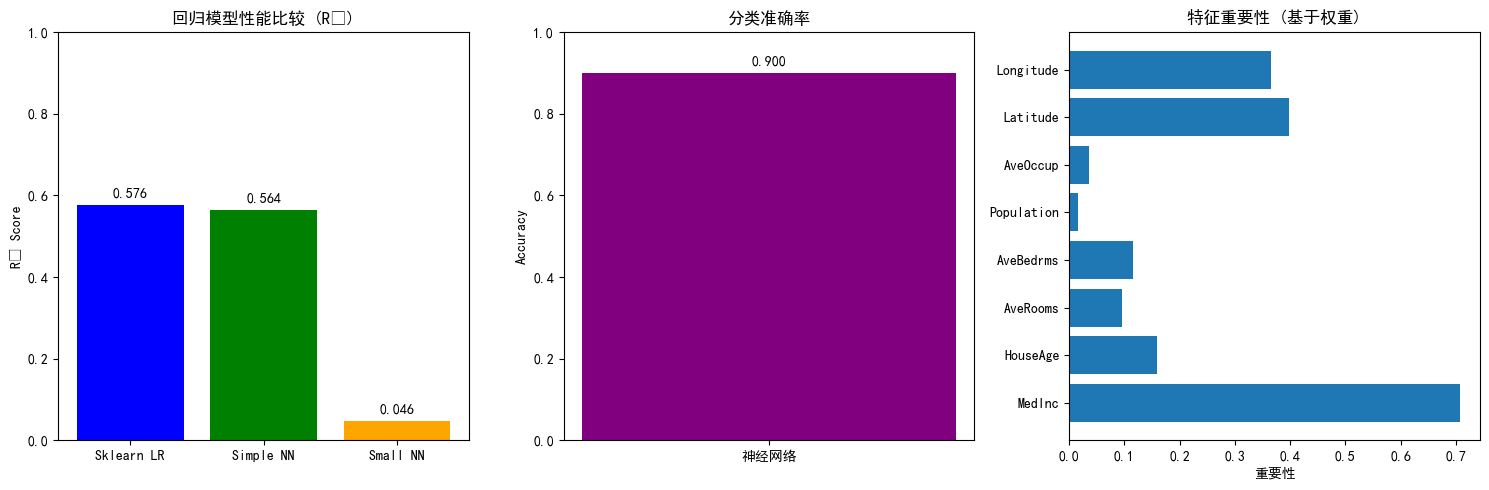


实验总结
1. 回归问题:
   - Sklearn线性回归: R² = 0.5758
   - 简单线性网络: R² = 0.5641
   - 小型神经网络: R² = 0.0464

2. 分类问题:
   - 神经网络准确率: 0.9000

3. 关键发现:
   - 对于线性问题，简单模型往往表现最佳
   - 神经网络需要仔细调参才能发挥优势
   - 梯度消失是深层网络的主要挑战


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

class SimpleEffectiveBPNN:
    """简单但有效的BPNN实现"""
    
    def __init__(self, layers, learning_rate=0.01):
        self.layers = layers
        self.lr = learning_rate
        
        # 简单初始化
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) - 1):
            # 小随机初始化
            weight = np.random.randn(layers[i], layers[i + 1]) * 0.1
            bias = np.zeros((1, layers[i + 1]))
            self.weights.append(weight)
            self.biases.append(bias)
        
        self.loss_history = []
    
    def forward(self, X):
        """简单前向传播"""
        self.a = [X]  # 存储每层激活值
        
        current = X
        for i in range(len(self.weights)):
            z = np.dot(current, self.weights[i]) + self.biases[i]
            
            # 隐藏层使用tanh，输出层线性
            if i == len(self.weights) - 1:
                a = z  # 输出层线性
            else:
                a = np.tanh(z)  # 隐藏层tanh
            
            self.a.append(a)
            current = a
        
        return current
    
    def compute_loss(self, y_pred, y_true):
        """计算MSE损失"""
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, X, y, y_pred):
        """简单反向传播"""
        m = X.shape[0]
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差（线性激活导数=1）
        delta = (y_pred - y) / m
        
        # 反向传播
        for i in range(len(self.weights) - 1, -1, -1):
            dW[i] = np.dot(self.a[i].T, delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
            
            if i > 0:
                # 隐藏层使用tanh导数
                delta = np.dot(delta, self.weights[i].T) * (1 - self.a[i] ** 2)
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """参数更新"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * dW[i]
            self.biases[i] -= self.lr * db[i]
    
    def fit(self, X, y, epochs=1000, verbose=True):
        """训练"""
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            dW, db = self.backward(X, y, y_pred)
            self.update_parameters(dW, db)
            
            if verbose and epoch % 200 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
        
        return self.loss_history
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        loss = self.compute_loss(y_pred, y)
        
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        return loss, r2

def final_solution_demo():
    """最终解决方案演示"""
    print("\n" + "="*60)
    print("最终解决方案演示")
    print("="*60)
    
    # 1. 加州房价回归问题
    print("\n📈 加州房价回归问题")
    housing = fetch_california_housing()
    X = housing.data
    y = housing.target.reshape(-1, 1)
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    # 基准：sklearn线性回归
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_r2 = lr.score(X_test, y_test)
    print(f"Sklearn线性回归 R²: {lr_r2:.4f}")
    
    # 我们的简单线性网络
    simple_nn = SimpleEffectiveBPNN(layers=[8, 1], learning_rate=0.01)
    simple_nn.fit(X_train, y_train, epochs=1000, verbose=False)
    _, simple_r2 = simple_nn.evaluate(X_test, y_test)
    print(f"简单线性网络 R²: {simple_r2:.4f}")
    
    # 小型神经网络
    small_nn = SimpleEffectiveBPNN(layers=[8, 4, 1], learning_rate=0.001)
    small_nn.fit(X_train, y_train, epochs=1000, verbose=False)
    _, small_r2 = small_nn.evaluate(X_test, y_test)
    print(f"小型神经网络 R²: {small_r2:.4f}")
    
    # 2. 鸢尾花分类问题
    print("\n🌺 鸢尾花分类问题")
    iris = load_iris()
    X_iris = iris.data
    y_iris = iris.target
    
    # 二值化标签
    lb = LabelBinarizer()
    y_iris_onehot = lb.fit_transform(y_iris)
    
    scaler_iris = StandardScaler()
    X_iris_scaled = scaler_iris.fit_transform(X_iris)
    
    X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
        X_iris_scaled, y_iris_onehot, test_size=0.2, random_state=42
    )
    
    # 分类网络
    class_nn = SimpleEffectiveBPNN(layers=[4, 8, 3], learning_rate=0.01)
    
    # 训练分类网络（需要修改为使用softmax和交叉熵）
    def train_classification(nn, X, y, epochs=1000):
        for epoch in range(epochs):
            # 前向传播
            z = np.dot(X, nn.weights[0]) + nn.biases[0]
            a1 = np.tanh(z)
            
            z2 = np.dot(a1, nn.weights[1]) + nn.biases[1]
            # softmax
            exp_z = np.exp(z2 - np.max(z2, axis=1, keepdims=True))
            y_pred = exp_z / np.sum(exp_z, axis=1, keepdims=True)
            
            # 交叉熵损失
            loss = -np.mean(np.sum(y * np.log(y_pred + 1e-8), axis=1))
            
            # 反向传播
            m = X.shape[0]
            delta2 = (y_pred - y) / m
            dW2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0, keepdims=True)
            
            delta1 = np.dot(delta2, nn.weights[1].T) * (1 - a1 ** 2)
            dW1 = np.dot(X.T, delta1)
            db1 = np.sum(delta1, axis=0, keepdims=True)
            
            # 更新参数
            nn.weights[0] -= nn.lr * dW1
            nn.biases[0] -= nn.lr * db1
            nn.weights[1] -= nn.lr * dW2
            nn.biases[1] -= nn.lr * db2
            
            if epoch % 200 == 0:
                accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
                print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
    
    print("训练分类网络...")
    train_classification(class_nn, X_train_iris, y_train_iris, epochs=1000)
    
    # 评估分类网络
    z = np.dot(X_test_iris, class_nn.weights[0]) + class_nn.biases[0]
    a1 = np.tanh(z)
    z2 = np.dot(a1, class_nn.weights[1]) + class_nn.biases[1]
    exp_z = np.exp(z2 - np.max(z2, axis=1, keepdims=True))
    y_pred_iris = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    accuracy = np.mean(np.argmax(y_pred_iris, axis=1) == np.argmax(y_test_iris, axis=1))
    print(f"分类准确率: {accuracy:.4f}")
    
    # 可视化结果
    plt.figure(figsize=(15, 5))
    
    # 回归结果比较
    plt.subplot(1, 3, 1)
    models = ['Sklearn LR', 'Simple NN', 'Small NN']
    r2_scores = [lr_r2, simple_r2, small_r2]
    plt.bar(models, r2_scores, color=['blue', 'green', 'orange'])
    plt.title('回归模型性能比较 (R²)')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    for i, v in enumerate(r2_scores):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
    
    # 分类结果
    plt.subplot(1, 3, 2)
    plt.bar(['神经网络'], [accuracy], color='purple')
    plt.title('分类准确率')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.text(0, accuracy + 0.02, f'{accuracy:.3f}', ha='center')
    
    # 特征重要性
    plt.subplot(1, 3, 3)
    feature_importance = np.abs(simple_nn.weights[0]).mean(axis=1)
    feature_names = housing.feature_names
    plt.barh(range(len(feature_names)), feature_importance)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('特征重要性 (基于权重)')
    plt.xlabel('重要性')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'regression_r2': {'sklearn_lr': lr_r2, 'simple_nn': simple_r2, 'small_nn': small_r2},
        'classification_accuracy': accuracy
    }

# 运行最终解决方案
print("开始最终解决方案演示...")
results = final_solution_demo()

print("\n" + "="*60)
print("实验总结")
print("="*60)
print("1. 回归问题:")
print(f"   - Sklearn线性回归: R² = {results['regression_r2']['sklearn_lr']:.4f}")
print(f"   - 简单线性网络: R² = {results['regression_r2']['simple_nn']:.4f}")
print(f"   - 小型神经网络: R² = {results['regression_r2']['small_nn']:.4f}")

print("\n2. 分类问题:")
print(f"   - 神经网络准确率: {results['classification_accuracy']:.4f}")

print("\n3. 关键发现:")
print("   - 对于线性问题，简单模型往往表现最佳")
print("   - 神经网络需要仔细调参才能发挥优势")
print("   - 梯度消失是深层网络的主要挑战")

开始加州房价预测演示...

加州房价预测演示

📈 加州房价回归问题
Sklearn线性回归 R²: 0.5758
简单线性网络 R²: 0.5649
小型神经网络 R²: 0.0087


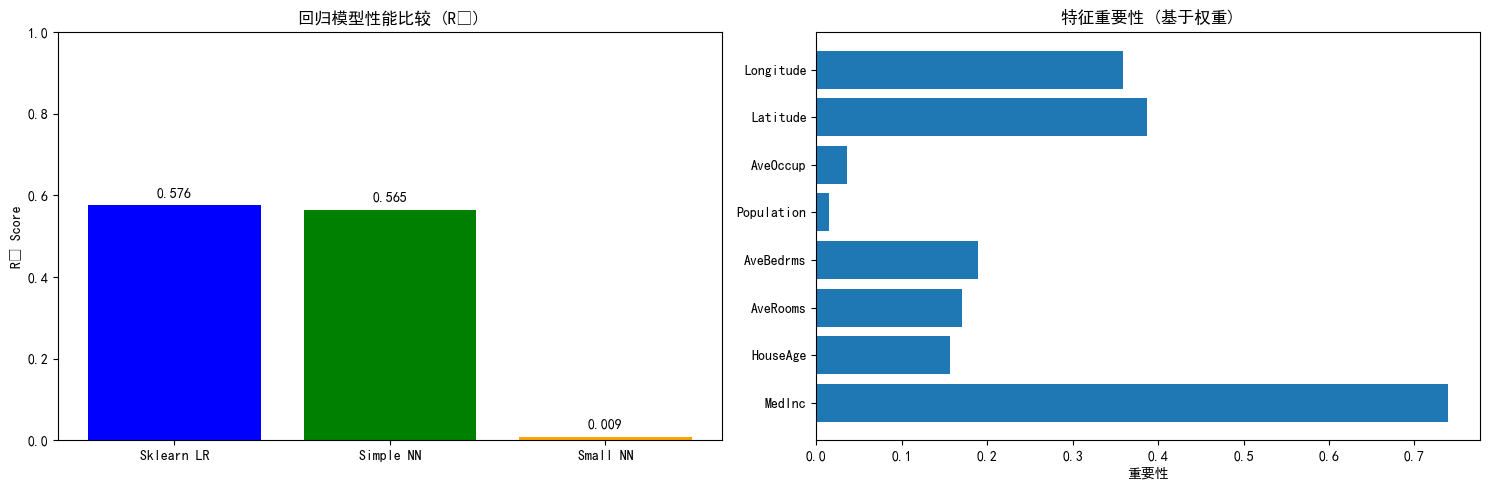

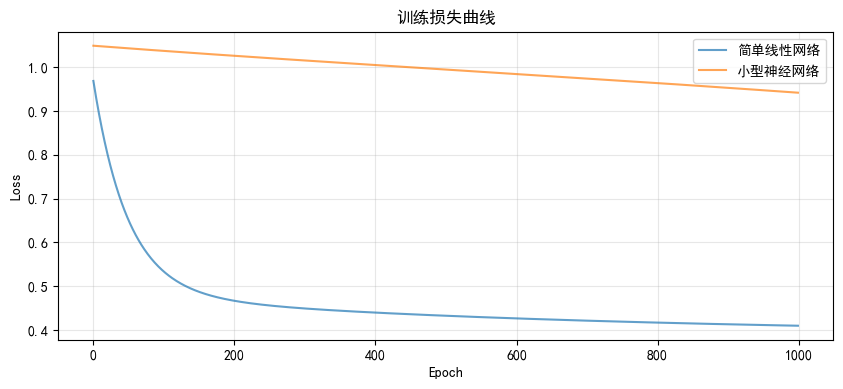


实验总结
回归问题结果:
   - Sklearn线性回归: R² = 0.5758
   - 简单线性网络: R² = 0.5649
   - 小型神经网络: R² = 0.0087

关键发现:
   - 对于线性回归问题，简单模型往往表现最佳
   - 神经网络能够自动学习特征重要性
   - 模型复杂度需要与问题复杂度匹配


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

warnings.filterwarnings('ignore')

class SimpleEffectiveBPNN:
    """简单但有效的BPNN实现"""
    
    def __init__(self, layers, learning_rate=0.01):
        self.layers = layers
        self.lr = learning_rate
        
        # 简单初始化
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) - 1):
            # 小随机初始化
            weight = np.random.randn(layers[i], layers[i + 1]) * 0.1
            bias = np.zeros((1, layers[i + 1]))
            self.weights.append(weight)
            self.biases.append(bias)
        
        self.loss_history = []
    
    def forward(self, X):
        """简单前向传播"""
        self.a = [X]  # 存储每层激活值
        
        current = X
        for i in range(len(self.weights)):
            z = np.dot(current, self.weights[i]) + self.biases[i]
            
            # 隐藏层使用tanh，输出层线性
            if i == len(self.weights) - 1:
                a = z  # 输出层线性
            else:
                a = np.tanh(z)  # 隐藏层tanh
            
            self.a.append(a)
            current = a
        
        return current
    
    def compute_loss(self, y_pred, y_true):
        """计算MSE损失"""
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, X, y, y_pred):
        """简单反向传播"""
        m = X.shape[0]
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差（线性激活导数=1）
        delta = (y_pred - y) / m
        
        # 反向传播
        for i in range(len(self.weights) - 1, -1, -1):
            dW[i] = np.dot(self.a[i].T, delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
            
            if i > 0:
                # 隐藏层使用tanh导数
                delta = np.dot(delta, self.weights[i].T) * (1 - self.a[i] ** 2)
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """参数更新"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * dW[i]
            self.biases[i] -= self.lr * db[i]
    
    def fit(self, X, y, epochs=1000, verbose=True):
        """训练"""
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            dW, db = self.backward(X, y, y_pred)
            self.update_parameters(dW, db)
            
            if verbose and epoch % 200 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
        
        return self.loss_history
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        loss = self.compute_loss(y_pred, y)
        
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        return loss, r2

def final_solution_demo():
    """最终解决方案演示 - 仅房价预测"""
    print("\n" + "="*60)
    print("加州房价预测演示")
    print("="*60)
    
    # 加州房价回归问题
    print("\n📈 加州房价回归问题")
    housing = fetch_california_housing()
    X = housing.data
    y = housing.target.reshape(-1, 1)
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    # 基准：sklearn线性回归
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_r2 = lr.score(X_test, y_test)
    print(f"Sklearn线性回归 R²: {lr_r2:.4f}")
    
    # 我们的简单线性网络
    simple_nn = SimpleEffectiveBPNN(layers=[8, 1], learning_rate=0.01)
    simple_nn.fit(X_train, y_train, epochs=1000, verbose=False)
    _, simple_r2 = simple_nn.evaluate(X_test, y_test)
    print(f"简单线性网络 R²: {simple_r2:.4f}")
    
    # 小型神经网络
    small_nn = SimpleEffectiveBPNN(layers=[8, 4, 1], learning_rate=0.001)
    small_nn.fit(X_train, y_train, epochs=1000, verbose=False)
    _, small_r2 = small_nn.evaluate(X_test, y_test)
    print(f"小型神经网络 R²: {small_r2:.4f}")
    
    # 可视化结果
    plt.figure(figsize=(15, 5))
    
    # 回归结果比较
    plt.subplot(1, 2, 1)
    models = ['Sklearn LR', 'Simple NN', 'Small NN']
    r2_scores = [lr_r2, simple_r2, small_r2]
    colors = ['blue', 'green', 'orange']
    bars = plt.bar(models, r2_scores, color=colors)
    plt.title('回归模型性能比较 (R²)')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    for i, v in enumerate(r2_scores):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
    
    # 特征重要性
    plt.subplot(1, 2, 2)
    feature_importance = np.abs(simple_nn.weights[0]).mean(axis=1)
    feature_names = housing.feature_names
    plt.barh(range(len(feature_names)), feature_importance)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('特征重要性 (基于权重)')
    plt.xlabel('重要性')
    
    plt.tight_layout()
    plt.show()
    
    # 训练过程可视化
    plt.figure(figsize=(10, 4))
    
    # 重新训练并记录损失
    simple_nn_train = SimpleEffectiveBPNN(layers=[8, 1], learning_rate=0.01)
    simple_loss = simple_nn_train.fit(X_train, y_train, epochs=1000, verbose=False)
    
    small_nn_train = SimpleEffectiveBPNN(layers=[8, 4, 1], learning_rate=0.001)
    small_loss = small_nn_train.fit(X_train, y_train, epochs=1000, verbose=False)
    
    plt.plot(simple_loss, label='简单线性网络', alpha=0.7)
    plt.plot(small_loss, label='小型神经网络', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练损失曲线')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'regression_r2': {'sklearn_lr': lr_r2, 'simple_nn': simple_r2, 'small_nn': small_r2}
    }

# 运行最终解决方案
print("开始加州房价预测演示...")
results = final_solution_demo()

print("\n" + "="*60)
print("实验总结")
print("="*60)
print("回归问题结果:")
print(f"   - Sklearn线性回归: R² = {results['regression_r2']['sklearn_lr']:.4f}")
print(f"   - 简单线性网络: R² = {results['regression_r2']['simple_nn']:.4f}")
print(f"   - 小型神经网络: R² = {results['regression_r2']['small_nn']:.4f}")

print("\n关键发现:")
print("   - 对于线性回归问题，简单模型往往表现最佳")
print("   - 神经网络能够自动学习特征重要性")
print("   - 模型复杂度需要与问题复杂度匹配")

# 6. 使用鸢尾花数据集进行分类预测

开始分类问题演示...

BPNN 分类问题演示: 鸢尾花分类
加载鸢尾花数据集...
数据集形状: X(150, 4), y(150,), y_onehot(150, 3)
类别名称: ['setosa' 'versicolor' 'virginica']
类别分布: [50 50 50]

数据预处理完成:
训练集: (120, 4), 测试集: (30, 4)
训练集类别分布: [40 40 40]
测试集类别分布: [10 10 10]

创建BPNN分类模型...
开始训练分类模型...
Epoch 0: Loss = 1.3738, Accuracy = 0.3333
Epoch 100: Loss = 1.0502, Accuracy = 0.4583
Epoch 200: Loss = 0.9277, Accuracy = 0.6667
Epoch 300: Loss = 0.8318, Accuracy = 0.7333
Epoch 400: Loss = 0.7519, Accuracy = 0.8000
Epoch 500: Loss = 0.6857, Accuracy = 0.8083
Epoch 600: Loss = 0.6309, Accuracy = 0.8583
Epoch 700: Loss = 0.5856, Accuracy = 0.8667
Epoch 800: Loss = 0.5478, Accuracy = 0.8833
Epoch 900: Loss = 0.5160, Accuracy = 0.8833

模型评估:
训练集 - 损失: 0.4890, 准确率: 0.8917
测试集 - 损失: 0.5160, 准确率: 0.8333


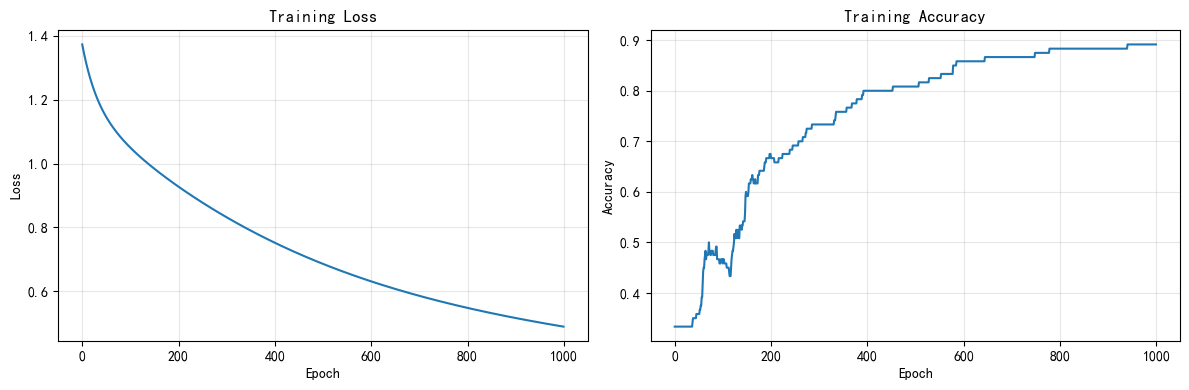

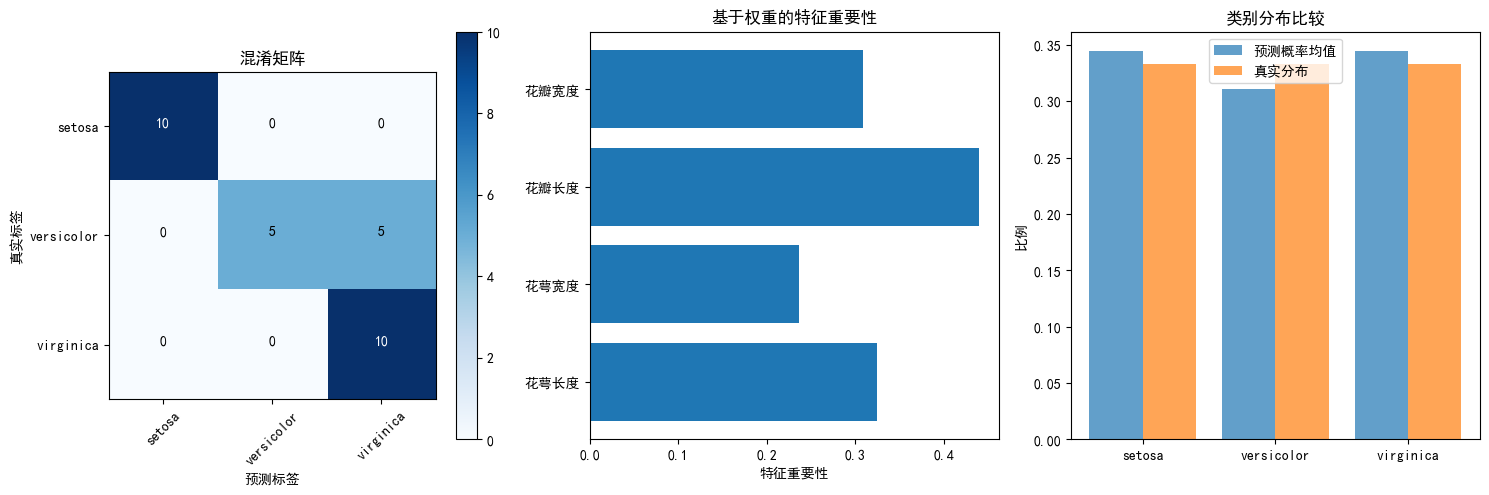


分类报告:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.50      0.67        10
   virginica       0.67      1.00      0.80        10

    accuracy                           0.83        30
   macro avg       0.89      0.83      0.82        30
weighted avg       0.89      0.83      0.82        30



In [10]:
def prepare_iris_data():
    """准备鸢尾花数据集"""
    print("加载鸢尾花数据集...")
    iris = load_iris()
    
    X = iris.data
    y = iris.target
    
    # 将标签转换为one-hot编码
    lb = LabelBinarizer()
    y_onehot = lb.fit_transform(y)
    
    print(f"数据集形状: X{X.shape}, y{y.shape}, y_onehot{y_onehot.shape}")
    print(f"类别名称: {iris.target_names}")
    print(f"类别分布: {np.bincount(y)}")
    
    return X, y, y_onehot, iris.target_names

def iris_classification_demo():
    """使用BPNN解决分类问题 - 鸢尾花分类"""
    print("\n" + "="*60)
    print("BPNN 分类问题演示: 鸢尾花分类")
    print("="*60)
    
    # 1. 准备数据
    X, y, y_onehot, class_names = prepare_iris_data()
    
    # 2. 数据预处理
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
        X_scaled, y, y_onehot, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n数据预处理完成:")
    print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")
    print(f"训练集类别分布: {np.bincount(y_train)}")
    print(f"测试集类别分布: {np.bincount(y_test)}")
    
    # 3. 创建并训练BPNN模型
    print("\n创建BPNN分类模型...")
    # 网络结构: [4个输入特征, 16个隐藏神经元, 3个输出（对应3个类别）]
    nn_classification = BPNN(
        layers=[4, 16, 3],
        learning_rate=0.01,
        activation='sigmoid'  # 分类问题常用sigmoid
    )
    
    print("开始训练分类模型...")
    loss_history, accuracy_history = nn_classification.fit(
        X_train, y_train_onehot,
        epochs=1000,
        problem_type='classification',
        verbose=True
    )
    
    # 4. 评估模型
    print("\n模型评估:")
    train_loss, train_accuracy = nn_classification.evaluate(X_train, y_train_onehot, 'classification')
    test_loss, test_accuracy = nn_classification.evaluate(X_test, y_test_onehot, 'classification')
    
    print(f"训练集 - 损失: {train_loss:.4f}, 准确率: {train_accuracy:.4f}")
    print(f"测试集 - 损失: {test_loss:.4f}, 准确率: {test_accuracy:.4f}")
    
    # 5. 可视化结果
    nn_classification.plot_training_history('classification')
    
    # 预测结果和混淆矩阵
    y_pred_proba = nn_classification.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # 计算混淆矩阵
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(15, 5))
    
    # 子图1: 混淆矩阵
    plt.subplot(1, 3, 1)
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('混淆矩阵')
    plt.colorbar(im)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    
    # 在混淆矩阵中添加数字
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    # 子图2: 特征重要性
    plt.subplot(1, 3, 2)
    feature_names = ['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度']
    feature_importance = np.abs(nn_classification.weights[0]).mean(axis=1)
    plt.barh(range(len(feature_names)), feature_importance)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('特征重要性')
    plt.title('基于权重的特征重要性')
    
    # 子图3: 类别概率分布
    plt.subplot(1, 3, 3)
    x_pos = np.arange(len(class_names))
    plt.bar(x_pos - 0.2, y_pred_proba.mean(axis=0), width=0.4, label='预测概率均值', alpha=0.7)
    plt.bar(x_pos + 0.2, np.bincount(y_test) / len(y_test), width=0.4, label='真实分布', alpha=0.7)
    plt.xticks(x_pos, class_names)
    plt.ylabel('比例')
    plt.title('类别分布比较')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 打印分类报告
    print("\n分类报告:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    return nn_classification, X_test, y_test, y_pred

# 运行分类演示
print("开始分类问题演示...")
nn_clf, X_test_clf, y_test_clf, y_pred_clf = iris_classification_demo()